# Week 2 – Classification
## Logistic Regression: From Intuition to Gradient Descent

In this notebook we will:

1. Motivate **classification** and compare it with linear regression.
2. Introduce the **logistic regression model**:
   $$
   f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)
   $$
3. Understand **decision boundaries**:
   - Linear boundaries in the original feature space.
   - Nonlinear boundaries via **feature transformations** (polynomial features).
4. Define the **logistic loss** and the **cost function**.
5. Derive and implement the **gradients** of the cost function.
6. Implement **gradient descent** and visualize **cost vs iterations**.

Notation (we keep it explicit and consistent):

- Vectors: $\vec{w}, \vec{x}$ (conceptual). In code they are NumPy arrays.
- Hypothesis (model): $f_{\vec{w}, b}(\vec{x})$.
- For sample $i$: $f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)})$.


In [1]:
%pip install numpy matplotlib 

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_PROTOCOL_VERSION] tlsv1 alert protocol version (_ssl.c:1020)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## 1. Motivation: Regression vs Classification

In **linear regression**, the goal is to predict a **real-valued output**:
$$
\hat{y} \in \mathbb{R}
$$

Examples:
- Predicting house prices.
- Predicting temperature.

In **binary classification**, the goal is to predict a **class label**:
$$
\hat{y} \in \{0, 1\}
$$

Examples:
- Email: spam ($y = 1$) vs not spam ($y = 0$).
- Transaction: fraudulent ($y = 1$) vs normal ($y = 0$).
- Tumor: malignant ($y = 1$) vs benign ($y = 0$).

Instead of predicting a raw number, we want a **probability** that the class is 1:
$$
f_{\vec{w}, b}(\vec{x}) = P(y = 1 \mid \vec{x}; \vec{w}, b)
$$

Then we can decide:
- Predict $\hat{y} = 1$ if $f_{\vec{w}, b}(\vec{x}) \ge 0.5$.
- Predict $\hat{y} = 0$ otherwise.


## 2. Logistic Regression Model

We define the **hypothesis** (model) as:
$$
f_{\vec{w}, b}(\vec{x}) = \sigma(z)
$$
where
$$
z = \vec{w} \cdot \vec{x} + b
$$

The function $\sigma(z)$ is the **sigmoid**:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Interpretation:
$$
f_{\vec{w}, b}(\vec{x}) = P(y = 1 \mid \vec{x}; \vec{w}, b)
$$

So for sample $i$:
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \sigma(\vec{w} \cdot \vec{x}^{(i)} + b)
$$

We will first visualize the sigmoid.


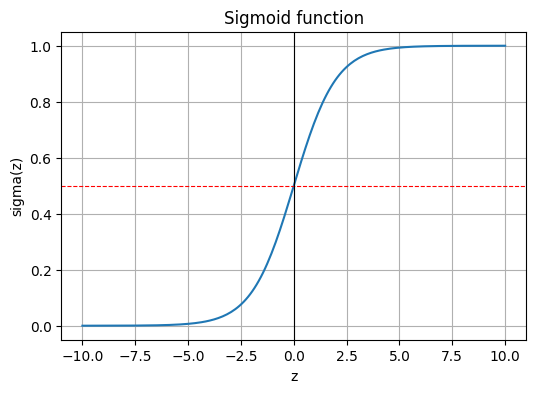

In [4]:
def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))


# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sig_values = sigmoid(z_values)

plt.figure()
plt.plot(z_values, sig_values)
plt.title("Sigmoid function")
plt.xlabel("z")
plt.ylabel("sigma(z)")
plt.ylim(-0.05, 1.05)
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

The plot shows $\sigma(z)$:

- For large negative $z$, $\sigma(z) \approx 0$.
- For large positive $z$, $\sigma(z) \approx 1$.
- At $z = 0$, $\sigma(0) = 0.5$.

This shape is ideal to model **probabilities**:

- If $z$ is very negative, $f_{\vec{w}, b}(\vec{x})$ is close to 0 (model is confident that $y = 0$).
- If $z$ is very positive, $f_{\vec{w}, b}(\vec{x})$ is close to 1 (model is confident that $y = 1$).
- Around $z = 0$, $f_{\vec{w}, b}(\vec{x}) \approx 0.5$ (model is uncertain).

Next, we connect this to **decision boundaries**.


## 3. Decision Boundary – Linear Case

Recall the hypothesis:
$$
f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b).
$$

Our prediction rule is:
$$
\hat{y} =
\begin{cases}
1 & \text{if } f_{\vec{w}, b}(\vec{x}) \ge 0.5 \\
0 & \text{otherwise.}
\end{cases}
$$

Because $\sigma(z) \ge 0.5$ if and only if $z \ge 0$, we have:
$$
f_{\vec{w}, b}(\vec{x}) \ge 0.5
\iff
\vec{w} \cdot \vec{x} + b \ge 0.
$$

The **decision boundary** is defined by the points where the model is exactly at probability 0.5:
$$
\vec{w} \cdot \vec{x} + b = 0.
$$

- In 2D ($x_1, x_2$), this is a **line**.
- In 3D, it is a **plane**.
- In general, it is a **hyperplane**.


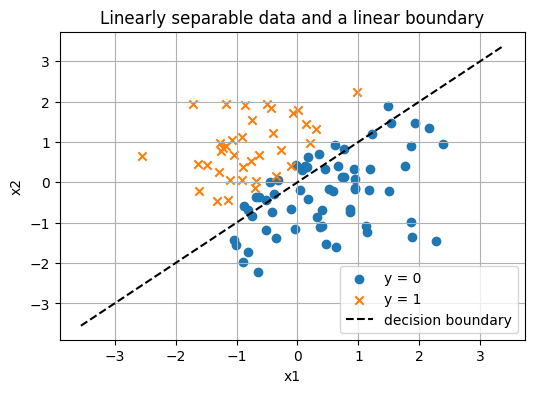

In [5]:
# Generate a simple linearly separable 2D dataset
np.random.seed(0)

m = 100  # number of examples
X_linear = np.random.randn(m, 2)

# Underlying "true" boundary: x2 = x1 + 0.5
# Label 1 if above the line, 0 if below
y_linear = (X_linear[:, 1] > X_linear[:, 0] + 0.5).astype(int)


def plot_linear_data_with_boundary(w, b, X, y, title):
    """Plot 2D data (X, y) and a linear decision boundary defined by w, b."""
    plt.figure()
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker="o", label="y = 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker="x", label="y = 1")

    # Decision boundary: w0*x1 + w1*x2 + b = 0  => x2 = -(w0*x1 + b) / w1
    x1_vals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    if abs(w[1]) > 1e-6:
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        plt.plot(x1_vals, x2_vals, "k--", label="decision boundary")
    else:
        x1_line = -b / w[0]
        plt.axvline(x1_line, color="k", linestyle="--", label="decision boundary")

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


# Example boundary (not trained yet)
w_example = np.array([1.0, -1.0])
b_example = 0.0

plot_linear_data_with_boundary(w_example, b_example, X_linear, y_linear,
                               "Linearly separable data and a linear boundary")

## 3.1 Nonlinear Boundaries via Feature Transformations

With the **original features** $x_1, x_2$, a logistic regression model
$$
f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)
$$
can only represent **linear** decision boundaries in the $(x_1, x_2)$ plane.

However, if we transform the input using a **feature mapping**:
$$
\vec{\phi}(\vec{x}) =
[x_1,\, x_2,\, x_1^2,\, x_2^2,\, x_1 x_2],
$$
and define the hypothesis in the new feature space as
$$
f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{\phi}(\vec{x}) + b),
$$
then the decision boundary is
$$
\vec{w} \cdot \vec{\phi}(\vec{x}) + b = 0,
$$
which is **linear in the feature space** of $\vec{\phi}(\vec{x})$, but can appear
**nonlinear in the original $(x_1, x_2)$ space** (e.g., circles, ellipses).

We now create a **circular dataset** to illustrate a nonlinear boundary (we will not train
the nonlinear model yet in this first hour, only set up the example).


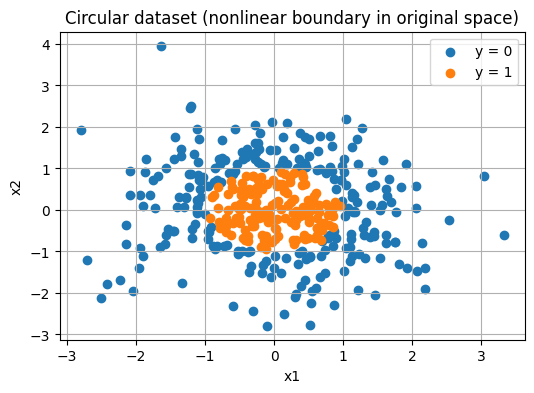

In [6]:
# Generate a circular dataset
np.random.seed(1)

m_circ = 400
X_circ = np.random.randn(m_circ, 2)
r = np.sqrt(X_circ[:, 0] ** 2 + X_circ[:, 1] ** 2)

# Label 1 if inside circle of radius ~1, else 0
y_circ = (r < 1.0).astype(int)

plt.figure()
plt.scatter(X_circ[y_circ == 0, 0], X_circ[y_circ == 0, 1], label="y = 0")
plt.scatter(X_circ[y_circ == 1, 0], X_circ[y_circ == 1, 1], label="y = 1")
plt.title("Circular dataset (nonlinear boundary in original space)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


def polynomial_features(X):
    """Simple polynomial feature mapping for 2D inputs.
    
    phi(x1, x2) = [x1, x2, x1^2, x2^2, x1*x2]
    """
    x1 = X[:, 0]
    x2 = X[:, 1]
    X_poly = np.column_stack([
        x1,
        x2,
        x1**2,
        x2**2,
        x1 * x2
    ])
    return X_poly

## 4. Cost Function for Logistic Regression

We want to choose $\vec{w}, b$ so that the model's predictions
$$
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)})
$$
are close to the true labels $y^{(i)}$.

For **logistic regression**, we use the **logistic loss** per example:
$$
\ell^{(i)} =
\begin{cases}
-\log\left(f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\right) & \text{if } y^{(i)} = 1, \\
-\log\left(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\right) & \text{if } y^{(i)} = 0.
\end{cases}
$$

Intuition:

- If $y^{(i)} = 1$, we want $f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})$ close to 1.  
  Then $-\log(\cdot)$ is small.
- If $y^{(i)} = 0$, we want $f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})$ close to 0.  
  Then $-\log(1 - \cdot)$ is small.
- **Confident wrong predictions** produce a very large loss.

The overall cost function is the average loss over all $m$ examples:
$$
J(\vec{w}, b) =
-\frac{1}{m}
\sum_{i=1}^m
\left[
y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})
+
(1 - y^{(i)}) \log\big(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\big)
\right].
$$


In [7]:
def compute_cost(w, b, X, y):
    """Compute logistic regression cost J(w, b) using explicit model."""
    m, n = X.shape

    # For each example i: f_{w,b}^{(i)}(x^{(i)}) = sigmoid(w^T x^{(i)} + b)
    z = X @ w + b
    f = sigmoid(z)

    # To avoid log(0), clip probabilities
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)

    J = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    return J


# Quick test on linear dataset with zero parameters
w_test = np.zeros(2)
b_test = 0.0
J_test = compute_cost(w_test, b_test, X_linear, y_linear)
J_test

np.float64(0.6931471805599453)

## 5. Gradients of the Cost Function

We want to minimize $J(\vec{w}, b)$ with respect to $\vec{w}$ and $b$.  
We use **gradient descent**, which requires the partial derivatives.

For each parameter $w_j$:
$$
\frac{\partial J}{\partial w_j}
=
\frac{1}{m}
\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right)
x^{(i)}_j,
$$
and for the bias:
$$
\frac{\partial J}{\partial b}
=
\frac{1}{m}
\sum_{i=1}^m
\left(
f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
\right).
$$

Vectorized view (conceptual):

1. Compute all $z^{(i)} = \vec{w} \cdot \vec{x}^{(i)} + b$ and
   $$
   f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = \sigma(z^{(i)}).
   $$
2. Define the error vector $\vec{e}$ with components
   $$
   e^{(i)} = f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}.
   $$
3. Then
   $$
   \nabla_{\vec{w}} J = \frac{1}{m} X^\top \vec{e}, \quad
   \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m e^{(i)}.
   $$

We now implement this in code.


In [8]:
def compute_gradient(w, b, X, y):
    """Compute gradients dJ/dw and dJ/db with explicit model."""
    m, n = X.shape

    # f_{w,b}^{(i)}(x^{(i)})
    z = X @ w + b
    f = sigmoid(z)

    error = f - y  # e^{(i)} = f_{w,b}^{(i)}(x^{(i)}) - y^{(i)}

    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)

    return dj_dw, dj_db


# Quick test
dj_dw_test, dj_db_test = compute_gradient(w_test, b_test, X_linear, y_linear)
dj_dw_test, dj_db_test

(array([ 0.29574313, -0.24721321]), np.float64(0.13))

## 6. Gradient Descent

To minimize $J(\vec{w}, b)$, we update the parameters in the opposite direction
of the gradient.

For each weight $w_j$:
$$
w_j := w_j - \alpha \frac{\partial J}{\partial w_j},
$$
and for the bias:
$$
b := b - \alpha \frac{\partial J}{\partial b},
$$

where $\alpha > 0$ is the **learning rate**.

Algorithm (high level):

1. Initialize $\vec{w}$ and $b$ (e.g., zeros).
2. Repeat for a number of iterations:
   - Compute $\frac{\partial J}{\partial w_j}$ and $\frac{\partial J}{\partial b}$.
   - Update $\vec{w}$ and $b$ with the rules above.
3. Track $J(\vec{w}, b)$ to see if it decreases.

We now implement gradient descent and train our model on the linear dataset.


In [9]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=0):
    """Run gradient descent to optimize w and b."""
    w = w_init.copy()
    b = b_init
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)

        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J(w, b) = {J:.4f}")

    return w, b, J_history


# Train on the linear dataset
m_lin, n_lin = X_linear.shape
w0 = np.zeros(n_lin)
b0 = 0.0

alpha = 0.5
num_iters = 200

w_trained, b_trained, J_hist = gradient_descent(
    X_linear, y_linear, w0, b0, alpha, num_iters, print_every=50
)

w_trained, b_trained

Iteration    0: J(w, b) = 0.6156
Iteration   50: J(w, b) = 0.1860
Iteration  100: J(w, b) = 0.1456
Iteration  150: J(w, b) = 0.1271
Iteration  199: J(w, b) = 0.1159


(array([-3.63395384,  3.18255063]), np.float64(-2.020644779139771))

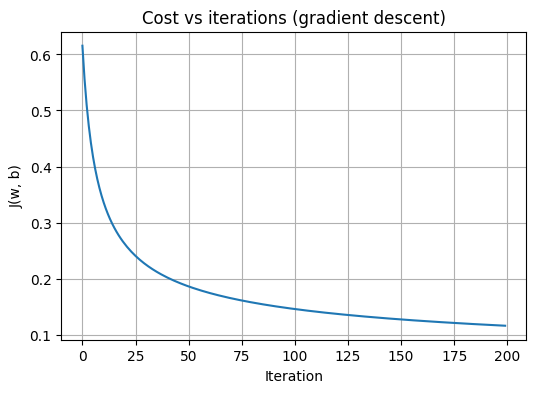

In [10]:
plt.figure()
plt.plot(J_hist)
plt.title("Cost vs iterations (gradient descent)")
plt.xlabel("Iteration")
plt.ylabel("J(w, b)")
plt.show()

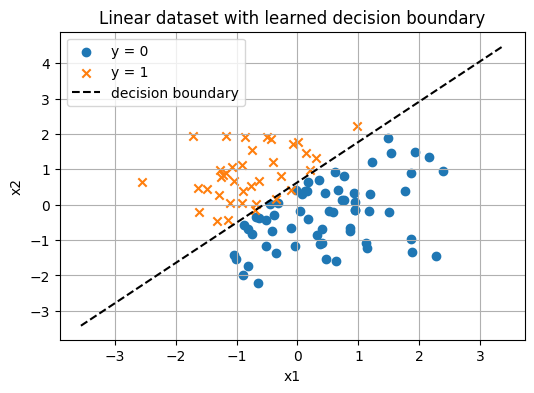

In [11]:
plot_linear_data_with_boundary(
    w_trained, b_trained, X_linear, y_linear,
    "Linear dataset with learned decision boundary"
)

## 7. Summary (Hour 1)

In this first hour we have:

1. **Motivation**  
   - Moved from predicting real values (regression) to predicting classes (classification).
   - Defined the model output as a probability:
     $$
     f_{\vec{w}, b}(\vec{x}) = P(y = 1 \mid \vec{x}; \vec{w}, b).
     $$

2. **Logistic regression model**  
   - Hypothesis:
     $$
     f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b).
     $$
   - Sigmoid $\sigma(z)$ maps any real number to the interval $(0, 1)$.
   - For each example:
     $$
     f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)}).
     $$

3. **Decision boundary**  
   - Prediction rule:
     $$
     f_{\vec{w}, b}(\vec{x}) \ge 0.5
     \iff
     \vec{w} \cdot \vec{x} + b \ge 0.
     $$
   - Decision boundary is given by
     $$
     \vec{w} \cdot \vec{x} + b = 0,
     $$
     which is linear in the original features.
   - With feature maps $\vec{\phi}(\vec{x})$, logistic regression can represent
     **nonlinear boundaries** in the original input space.

4. **Cost function**  
   - Per-example logistic loss:
     $$
     \ell^{(i)} =
     -\left[
     y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})
     +
     (1 - y^{(i)}) \log\left(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\right)
     \right].
     $$
   - Overall cost:
     $$
     J(\vec{w}, b) =
     -\frac{1}{m}
     \sum_{i=1}^m
     \left[
     y^{(i)} \log f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})
     +
     (1 - y^{(i)}) \log\left(1 - f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)})\right)
     \right].
     $$

5. **Gradients and gradient descent**  
   - Gradients:
     $$
     \frac{\partial J}{\partial w_j}
     =
     \frac{1}{m}
     \sum_{i=1}^m
     \left(
     f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
     \right) x_j^{(i)},
     $$
     $$
     \frac{\partial J}{\partial b}
     =
     \frac{1}{m}
     \sum_{i=1}^m
     \left(
     f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) - y^{(i)}
     \right).
     $$
   - Gradient descent updates:
     $$
     w_j := w_j - \alpha \frac{\partial J}{\partial w_j}, \quad
     b := b - \alpha \frac{\partial J}{\partial b}.
     $$
   - We implemented gradient descent, observed the **cost decreasing**, and visualized
     the **learned decision boundary** on a 2D dataset.

